# 扩展PyTorch

[参考](https://pytorch.org/docs/stable/notes/extending.html)

## Extending torch.autograd

In [7]:
import torch
import math


class LegendrePolynomial3(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return grad_output * 1.5 * (5 * input ** 2 - 1)


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0")  # Uncomment this to run on GPU

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Create random Tensors for weights. For this example, we need
# 4 weights: y = a + b * P3(c + d * x), these weights need to be initialized
# not too far from the correct result to ensure convergence.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

learning_rate = 5e-6
for t in range(2000):
    # To apply our Function, we use Function.apply method. We alias this as 'P3'.
    P3 = LegendrePolynomial3.apply

    # Forward pass: compute predicted y using operations; we compute
    # P3 using our custom autograd operation.
    y_pred = a + b * P3(c + d * x)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

99 209.95834350585938
199 144.66018676757812
299 100.70249938964844
399 71.03519439697266
499 50.978511810302734
599 37.403133392333984
699 28.206867218017578
799 21.97318458557129
899 17.7457275390625
999 14.877889633178711
1099 12.93176555633545
1199 11.610918045043945
1299 10.71425724029541
1399 10.10548210144043
1499 9.692105293273926
1599 9.411375999450684
1699 9.220745086669922
1799 9.091285705566406
1899 9.003361701965332
1999 8.943641662597656
Result: y = -6.71270206087371e-10 + -2.208526849746704 * P3(-3.392665037793563e-10 + 0.2554861009120941 x)


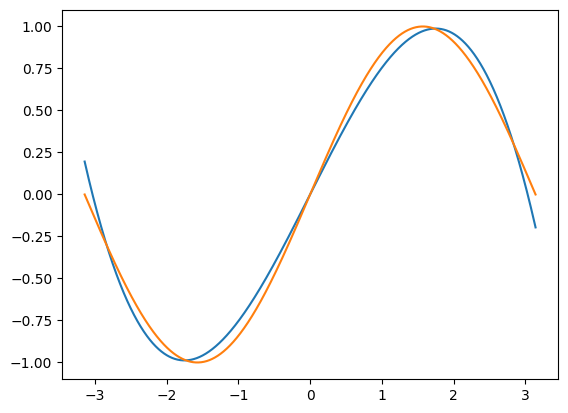

In [16]:
import matplotlib.pyplot as plt
plt.plot(x.detach().numpy(),y_pred.detach().numpy(),label="pred")
plt.plot(x.detach().numpy(),y.detach().numpy(),label="ref")

## Extending torch.nn

In [18]:
import torch.nn as nn
class Linear(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.empty(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        nn.init.uniform_(self.weight, -0.1, 0.1)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        return LinearFunction.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )